In [1]:
#### import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import pandas as pd
import os 
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
class ClutteredMNISTDataset(Sequence):
    reg_dataset_size = 11276

    def __init__(self, base_path, csv_path, data_scaling=1., num_examples=None, balance=None, num_classes=2):
        self.base_path = base_path
        self.csv_path = csv_path
        self.csv = pd.read_csv(csv_path)
        self.data_scaling = data_scaling
        self.num_examples = num_examples
        self.balance = balance
        self.num_classes = num_classes
        self.img_paths = self.csv['img_path'].values
        self.lbls = self.csv['label'].values.astype(np.int32)
        self.weights = np.ones([len(self.img_paths), ])

        if self.num_examples is not None and self.balance is not None:
            # only rebalance if examples and balance is given
            assert self.num_examples <= len(self.img_paths), \
                'not enough examples in dataset {} - {}'.format(self.num_examples, len(self.img_paths))

            pos_num = int(self.balance * self.num_examples)
            neg_num = self.num_examples - pos_num

            pos_mask = (self.lbls == 1)
            pos_paths = self.img_paths[pos_mask][:pos_num]

            neg_mask = (self.lbls == 0)
            neg_paths = self.img_paths[neg_mask][:neg_num]

            self.img_paths = np.concatenate([pos_paths, neg_paths], 0)
            self.lbls = np.concatenate([np.ones([pos_num, ]), np.zeros([neg_num, ])], 0)
            self.weights = np.ones([self.num_examples, ])
            self.weights[:pos_num] /= pos_num
            self.weights[pos_num:] /= neg_num

        self.shrinkage = self.reg_dataset_size // len(self.img_paths)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        path = os.path.join(self.base_path, self.img_paths[index])
        lbl = self.lbls[index].astype(np.int64)
        lbl = np.eye(self.num_classes)[lbl].astype(np.int64)
        img = np.load(path)
        if isinstance(img, np.lib.npyio.NpzFile):
            img = img['arr_0']

        if self.data_scaling != 1.:
            img = zoom(img, self.data_scaling)
            img = img.clip(0., 1.)

        img = (img[:,:,np.newaxis].astype(np.float32).astype(np.float32) -0.5)/1

        return img, lbl
    

class Batcher(Sequence):
    """Assemble a sequence of things into a sequence of batches."""
    def __init__(self, sequence, batch_size=16):
        self._batch_size = batch_size
        self._sequence = sequence
        self._idxs = np.arange(len(self._sequence))

    def __len__(self):
        return int(np.ceil(len(self._sequence) / self._batch_size))

    def __getitem__(self, i):
        if i >= len(self):
            raise IndexError("Index out of bounds")

        start = i*self._batch_size
        end = min(len(self._sequence), start+self._batch_size)
        data = [self._sequence[j] for j in self._idxs[start:end]]
        inputs = [d[0] for d in data]
        outputs = [d[1] for d in data]

        return self._stack(inputs), self._stack(outputs)

    def _stack(self, data):
        if data is None:
            return None

        if not isinstance(data[0], (list, tuple)):
            return np.stack(data)

        seq = type(data[0])
        K = len(data[0])
        data = seq(
            np.stack([d[k] for d in data])
            for k in range(K)
        )

        return data

    def on_epoch_end(self):
        np.random.shuffle(self._idxs)
        self._sequence.on_epoch_end()
        
        
        
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
from tensorflow.keras.utils import to_categorical
tn.set_default_backend("tensorflow")




class GridMERAin16(tf.keras.layers.Layer):
    
    def __init__(self, kernel_dims, bond_dims, output_dims):
        super(GridMERAin16, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        in_dims = int((kernel_dims//4)**2)
        self.entanglers = []
        self.isometries= []
        self.kernel_dims = kernel_dims
        self.output_dims = output_dims
        #entanglers
        self.entanglers1 = tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        self.entanglers2 = tf.Variable(tf.random.normal
                                             (shape=(bond_dims, bond_dims, 
                                                     bond_dims, bond_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/100000),
                                            trainable=True), 
                           tf.Variable(tf.random.normal(shape=(in_dims, in_dims, bond_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/100000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(in_dims, bond_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/100000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(bond_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/100000),
                                            trainable=True)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/100000),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers1, entanglers2, isometries1, isometries2, bias_var, kernel_dims):
            input_vv = []
            step = int(kernel_dims//4)
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*step:i*step+step, ii*step:ii*step+step, 0], (1, step**2)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, step**2))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
            e_nodes1 = tn.Node(entanglers1)
            e_nodes2 = tn.Node(entanglers2)
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
            
            e_nodes1[0] ^ input_nodes[5][0]
            e_nodes1[1] ^ input_nodes[6][0]
            e_nodes1[2] ^ input_nodes[9][0]
            e_nodes1[3] ^ input_nodes[10][0]

            e_nodes1[4] ^ isometries_nodes1[0][3]
            e_nodes1[5] ^ isometries_nodes1[1][2]
            e_nodes1[6] ^ isometries_nodes1[2][1]
            e_nodes1[7] ^ isometries_nodes1[3][0]     
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            
            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ e_nodes2[0]
            isometries_nodes1[1][4] ^ e_nodes2[1]
            isometries_nodes1[2][4] ^ e_nodes2[2]
            isometries_nodes1[3][4] ^ e_nodes2[3]

            e_nodes2[4] ^ isometries_nodes2[0]
            e_nodes2[5] ^ isometries_nodes2[1]
            e_nodes2[6] ^ isometries_nodes2[2]
            e_nodes2[7] ^ isometries_nodes2[3]

                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers1, self.entanglers2,
                                                 self.isometries1,  self.isometries2, self.bias, self.kernel_dims), inputs)
        return tf.reshape(output, (-1, self.output_dims))
    
from tensorflow.keras.layers import Lambda, Input, Concatenate, Reshape, Softmax, Dense, Flatten
from tensorflow.keras.models import Model, Sequential

def get_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_out_list = []
    for i in range(8):
        for j in range(8):
            subx = Lambda(lambda x:x[:, 8*i:8*(i+1),8*j:8*(j+1),:] )(x_in)
            x_out_list.append(GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=1)(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Reshape(target_shape=(8, 8, 1))(x_out)
    y = GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=2)(x_out)
    y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)

def get_dense_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_out_list = []
    for i in range(8):
        for j in range(8):
            subx = Lambda(lambda x:x[:, 8*i:8*(i+1),8*j:8*(j+1),:] )(x_in)
            x_out_list.append(GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=2)(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Flatten()(x_out)
    y = Dense(2, activation='softmax')(x_out)
    #x_out = Reshape(target_shape=(8, 8, 1))(x_out)
    #y = GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=2)(x_out)
    #y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)

def get_loop_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_out_list = []
    MERA_layer = GridMERAin16(kernel_dims=16, bond_dims=2, output_dims=2)
    for i in range(4):
        for j in range(4):
            subx = Lambda(lambda x:x[:, 16*i:16*(i+1),16*j:16*(j+1),:] )(x_in)
            x_out_list.append(MERA_layer(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Flatten()(x_out)
    y = Dense(2, activation='softmax')(x_out)
    #x_out = Reshape(target_shape=(8, 8, 1))(x_out)
    #y = GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=2)(x_out)
    #y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)

def get_loop4_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_out_list = []
    MERA_layer = GridMERAin16(kernel_dims=4, bond_dims=2, output_dims=2)
    for i in range(16):
        for j in range(16):
            subx = Lambda(lambda x:x[:, 4*i:4*(i+1),4*j:4*(j+1),:] )(x_in)
            x_out_list.append(MERA_layer(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Flatten()(x_out)
    y = Dense(2, activation='softmax')(x_out)
    #x_out = Reshape(target_shape=(8, 8, 1))(x_out)
    #y = GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=2)(x_out)
    #y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)

def get_deep_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_in2_list = []
    for i in range(16):
        for j in range(16):
            subx = Lambda(lambda x:x[:, 4*i:4*(i+1),4*j:4*(j+1),:] )(x_in)
            x_in2_list.append(GridMERAin16(kernel_dims=1, bond_dims=2, output_dims=1)(subx))
    x_in2 = Concatenate(axis=1)(x_in2_list)
    x_in2 = Reshape(target_shape=(16, 16, 1))(x_in2)
    x_out_list = []
    for i in range(4):
        for j in range(4):
            subx = Lambda(lambda x:x[:, 4*i:4*(i+1),4*j:4*(j+1),:] )(x_in2)
            x_out_list.append(GridMERAin16(kernel_dims=1, bond_dims=2, output_dims=1)(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Reshape(target_shape=(4, 4, 1))(x_out)
    y = GridMERAin16(kernel_dims=1, bond_dims=2, output_dims=2)(x_out)
    y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)



In [2]:
batch_size = 64

data_path = '/datacommons/carin/fk43/NeedleinHaystack/mnist128_0/'
train_data=ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'train.csv'), data_scaling=1., num_examples=3000, balance=0.5)
val_data = ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'val.csv'), data_scaling=1., num_examples=1000, balance=0.5)
test_data = ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'test.csv'), data_scaling=1., num_examples=1000, balance=0.5)


train_data = Batcher(train_data, batch_size=batch_size)
val_data = Batcher(val_data, batch_size=batch_size)
test_data = Batcher(test_data, batch_size=batch_size)

In [3]:
train_data.__getitem__(0)[0].shape

(64, 128, 128, 1)

In [4]:
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

model = tf.keras.Sequential()
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(128,128,1)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv2'))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv3'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv4'))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv5'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
#model.add(Dense(1936, activation='relu', name='fc1'))
model.add(Dense(2, activation='softmax', name='fc2'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 4)       40        
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 4)       148       
_________________________________________________________________
conv3 (Conv2D)               (None, 122, 122, 4)       148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 4)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 59, 59, 4)         148       
_________________________________________________________________
conv5 (Conv2D)               (None, 57, 57, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 4)         0

In [7]:
%%time

# Traditional model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
hist = model.fit_generator(train_data, validation_data=val_data, epochs=20, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 16 steps
Epoch 1/20
47/47 [==============================] - 12s 258ms/step - loss: 0.7104 - accuracy: 0.4820 - val_loss: 0.6913 - val_accuracy: 0.5730
Epoch 2/20
47/47 [==============================] - 6s 133ms/step - loss: 0.7133 - accuracy: 0.5733 - val_loss: 0.6815 - val_accuracy: 0.6780
Epoch 3/20
47/47 [==============================] - 6s 118ms/step - loss: 0.6636 - accuracy: 0.6477 - val_loss: 0.6423 - val_accuracy: 0.6710
Epoch 4/20
47/47 [==============================] - 6s 128ms/step - loss: 0.5995 - accuracy: 0.7047 - val_loss: 0.5746 - val_accuracy: 0.7010
Epoch 5/20
47/47 [==============================] - 6s 127ms/step - loss: 0.5693 - accuracy: 0.7007 - val_loss: 0.6090 - val_accuracy: 0.7120
Epoch 6/20
47/47 [==============================] - 6s 125ms/step - loss: 0.5361 - accuracy: 0.7280 - val_loss: 0.5510 - 

In [73]:
model.evaluate_generator(test_data, int(np.ceil(1000/batch_size)), workers = 1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[0.5210905503481627, 0.739]

In [86]:
class TNLayer(tf.keras.layers.Layer):
    
    def __init__(self, dim):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(dim, dim)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (self.dim, self.dim))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0]
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))
    
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tn_model = tf.keras.Sequential()
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(128,128,1)))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv4'))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv5'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(tf.keras.layers.Flatten())
tn_model.add(TNLayer(56))
tn_model.add(Dense(2, activation='softmax', name='fc2'))
tn_model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 4)       40        
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 4)       148       
_________________________________________________________________
conv3 (Conv2D)               (None, 122, 122, 4)       148       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 61, 61, 4)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 59, 59, 4)         148       
_________________________________________________________________
conv5 (Conv2D)               (None, 57, 57, 4)         148       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 28, 28, 4)       

In [87]:
%%time

# TensorNetwork model
tn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0002, clipnorm=0.1), metrics=['accuracy'])
tn_hist = tn_model.fit_generator(train_data, validation_data=val_data, epochs=20, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 16 steps
Epoch 1/20
47/47 [==============================] - 8s 163ms/step - loss: 0.7049 - accuracy: 0.4360 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/20
47/47 [==============================] - 6s 123ms/step - loss: 0.6979 - accuracy: 0.4600 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/20
47/47 [==============================] - 6s 120ms/step - loss: 0.6952 - accuracy: 0.4230 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
47/47 [==============================] - 6s 121ms/step - loss: 0.6958 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 5/20
47/47 [==============================] - 6s 121ms/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 6/20
47/47 [==============================] - 6s 120ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/20
47/47 [==============================] - 6s 1

In [88]:
tn_model.evaluate_generator(test_data, int(np.ceil(1000/batch_size)), workers = 1)

  ...
    to  
  ['...']


[0.48420812748372555, 0.757]

In [81]:
tn_model = tf.keras.Sequential()
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(128,128,1)))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv4'))
tn_model.add(Conv2D(4, kernel_size=(3,3), activation='relu', name='conv5'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(tf.keras.layers.Flatten())
tn_model.add(TNLayer(56))
tn_model.add(Dense(2, activation='softmax', name='fc2'))
tn_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 4)       40        
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 4)       148       
_________________________________________________________________
conv3 (Conv2D)               (None, 122, 122, 4)       148       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 61, 61, 4)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 59, 59, 4)         148       
_________________________________________________________________
conv5 (Conv2D)               (None, 57, 57, 4)         148       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 28, 28, 4)       

In [77]:
%%time

# TensorNetwork model
tn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(0.01, clipnorm=1.2), metrics=['accuracy'])
MERA_hist = tn_model.fit_generator(train_data, validation_data=val_data, epochs=10, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 16 steps
Epoch 1/10
47/47 [==============================] - 8s 166ms/step - loss: 0.7285 - accuracy: 0.4547 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - 6s 125ms/step - loss: 0.6988 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/10
47/47 [==============================] - 6s 126ms/step - loss: 0.6993 - accuracy: 0.4147 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/10
47/47 [==============================] - 6s 125ms/step - loss: 0.6986 - accuracy: 0.3933 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/10
47/47 [==============================] - 6s 124ms/step - loss: 0.6995 - accuracy: 0.4787 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/10
47/47 [==============================] - 6s 126ms/step - loss: 0.6953 - accuracy: 0.4547 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/10
47/47 [==============================] - 6s 1

In [82]:
%%time

# TensorNetwork model
tn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(0.0002, clipnorm=0.5), metrics=['accuracy'])
MERA_hist2 = tn_model.fit_generator(train_data, validation_data=val_data, epochs=10, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 16 steps
Epoch 1/10
47/47 [==============================] - 7s 141ms/step - loss: 0.6960 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - 6s 120ms/step - loss: 0.6949 - accuracy: 0.4183 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/10
47/47 [==============================] - 6s 122ms/step - loss: 0.6939 - accuracy: 0.4050 - val_loss: 0.6928 - val_accuracy: 0.6940
Epoch 4/10
47/47 [==============================] - 6s 136ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6924 - val_accuracy: 0.5290
Epoch 5/10
47/47 [==============================] - 6s 120ms/step - loss: 0.6923 - accuracy: 0.5060 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 6/10
47/47 [==============================] - 6s 119ms/step - loss: 0.6871 - accuracy: 0.5857 - val_loss: 0.6808 - val_accuracy: 0.6470
Epoch 7/10
47/47 [==============================] - 6s 1

In [85]:
tn_model.evaluate_generator(test_data, int(np.ceil(1000/batch_size)), workers = 1)

  ...
    to  
  ['...']


[0.5370095558464527, 0.714]

In [83]:
MERA_hist.history['accuracy']

[0.45466667,
 0.5,
 0.41466665,
 0.39333335,
 0.47866666,
 0.45466667,
 0.45733333,
 0.396,
 0.5,
 0.5]

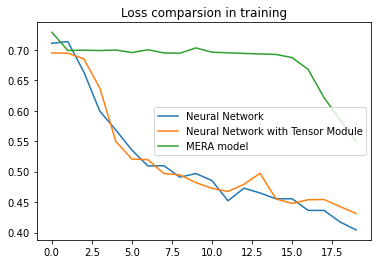

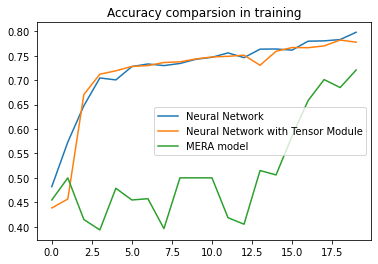

In [84]:
loss = hist.history['loss']
acc = hist.history['accuracy']
tn_loss = tn_hist.history['loss']
tn_acc = tn_hist.history['accuracy']
MERA_loss = MERA_hist.history['loss'] + MERA_hist2.history['loss'] 
MERA_acc = MERA_hist.history['accuracy'] + MERA_hist2.history['accuracy']

plt.plot(loss, label='Neural Network')
plt.plot(tn_loss, label='Neural Network with Tensor Module')
plt.plot(MERA_loss, label='MERA model')
plt.title('Loss comparsion in training')
#plt.ylim(0, 0.15)
plt.legend()
plt.show()

plt.plot(acc, label='Neural Network')
plt.plot(tn_acc, label='Neural Network with Tensor Module')
plt.plot(MERA_acc, label='MERA model')
plt.title('Accuracy comparsion in training')
plt.legend()
plt.show()